In [215]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Data Cleaning (4 datasets)

## Data 1: Employee Demographics


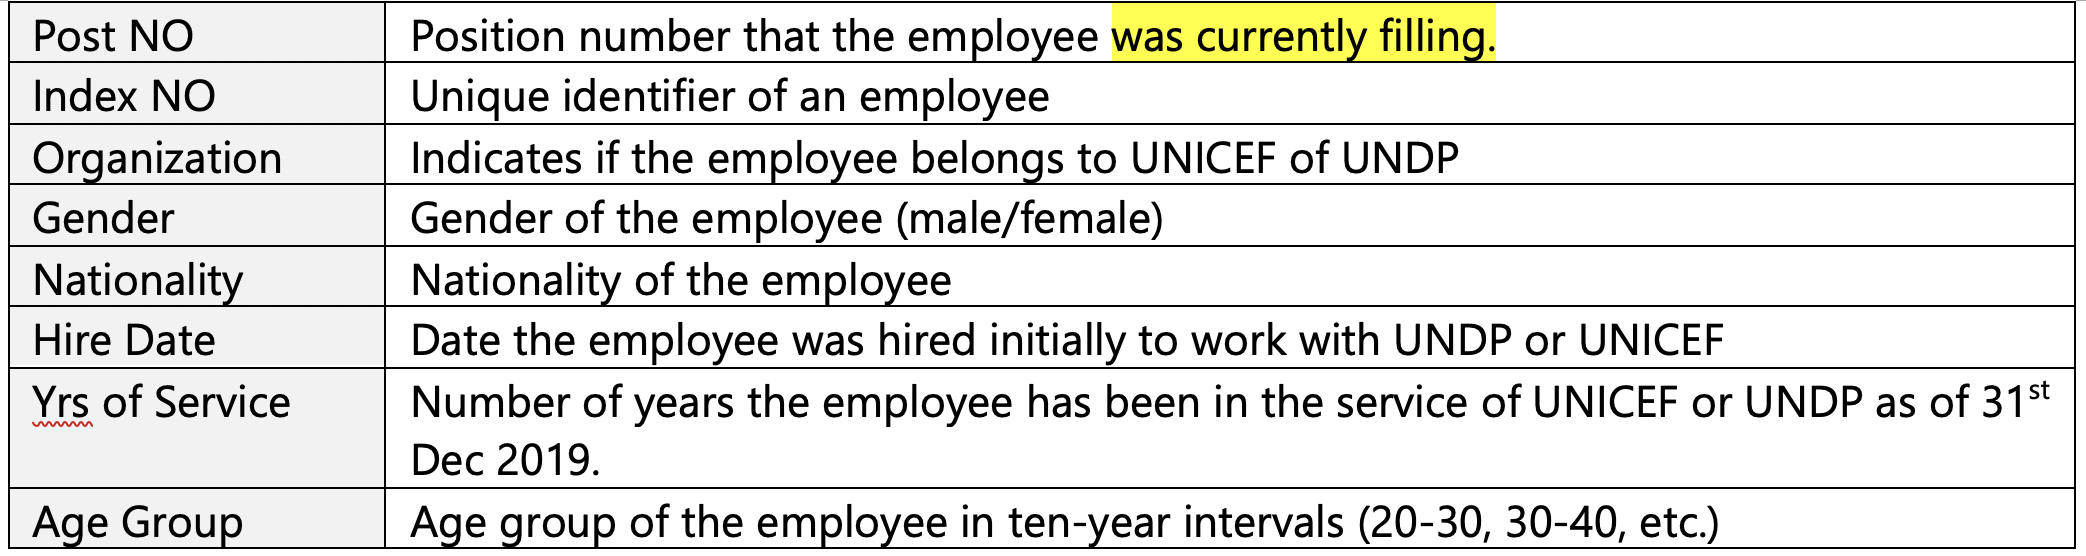

In [216]:
emp_de = pd.read_csv('Employee_Demographics.txt', sep=",", names=['Post No','Index No','Organization','Gender','Nationality','Hire Date','Yrs Of Service','Age Group', 'Others'])
emp_de = emp_de.iloc[1: , :]
emp_de.head()

,Post No,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age Group,Others
1,SSSSZKOA,FSZKZS,UNDP,Female,Myanmar,1979-10-01 00:00:00.000,40,60-69,NaN
2,SSSSZKOR,SAZSKZ,UNDP,Male,Myanmar,2013-07-08 00:00:00.000,6,50-59,NaN
3,SSSSZKOP,SFZRXX,UNDP,Male,Myanmar,1994-11-22 00:00:00.000,25,60-69,NaN
4,SSSSZKKX,RSPXSR,UNDP,Female,Myanmar,1996-11-01 00:00:00.000,23,50-59,NaN
5,SSSSZKKA,XKRXPZ,UNDP,Male,Sri Lanka,1999-07-01 00:00:00.000,20,40-49,NaN


In [217]:
# Select rows only with normal 'Hire Date' & 'Nationality': Hire Date that doesn't contain letters. 

normal = emp_de[emp_de['Hire Date'].str.contains('\d', na=False, regex=True)] # 'Hire Date' with numbers
normal = normal.drop(['Others'], axis=1)

# There is 'Hire Date' with ' UNSCR1244 (1999)' as it contains numbers
# Remove it for now...
normal = normal[normal['Hire Date'] != ' UNSCR1244 (1999)']

# Select rows with abnormal 'Hire Date' which contains the following strings.
#' United Republic of',' Republic of',' The Democratic Republic',' UNSCR1244 (1999)'
#" Democratic People's Rep"," TFYR","Rep","Peo.Dem.Rep"," Federated States"," Dem. Rep"," Rep of"," DPR"

abnormal = emp_de[~emp_de['Hire Date'].str.contains('\d', na=False, regex=True)] # 'Hire Date' not with numbers
abnormal.head()


,Post No,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age Group,Others
134,SSSSXXAO,DFXSO,UNDP,Male,Tanzania,United Republic of,1999-12-01 00:00:00.000,20,70-79
135,SSSSXXAF,PDKPXD,UNDP,Male,Tanzania,United Republic of,2013-07-01 00:00:00.000,6,50-59
136,SSSSXXAF,DZFADS,UNDP,Male,Tanzania,United Republic of,1998-07-01 00:00:00.000,21,50-59
137,SSSSXXAR,DOPXR,UNDP,Female,Tanzania,United Republic of,2002-01-16 00:00:00.000,18,50-59
138,SSSSXXRZ,AFKDOO,UNDP,Male,Tanzania,United Republic of,2016-06-01 00:00:00.000,3,30-39


In [218]:
# Combine 'Nationality' string and 'Hire Date' string as one country name
abnormal['Nationality'] = abnormal['Nationality'] + abnormal['Hire Date']

# Drop unnecessary column, 'Hire Date' and reassign column names
abnormal = abnormal.drop(['Hire Date'], axis=1)
abnormal.columns = ['Post No', 'Index No', 'Organization', 'Gender', 'Nationality',
       'Hire Date', 'Yrs Of Service', 'Age Group']

# Combine two cleaned dataframes
result = normal.append(abnormal)

# Remove "00:00:00.000"
result['Hire Date']= result['Hire Date'].str.replace("\s00:00:00.000", "")

# To datetime
result['Hire Date'] = pd.to_datetime(result['Hire Date'])

In [219]:
# Drop if 'Hire Date' has NaT
result = result[result['Hire Date'].notnull()]  

result['Yrs Of Service'] = result['Yrs Of Service'].astype('str')


In [220]:
# Drop if 'Yrs Of Service' is 'nan'
result = result[result['Yrs Of Service'] != 'nan']

# 'Yrs Of Service' into integer
result['Yrs Of Service'] = pd.to_numeric(result['Yrs Of Service']).astype('int')


In [221]:
#'Age Group' : Re-categorize
# Make the form of age categories consistent
result['Age Group']= result['Age Group'].str.replace("40 to 49", "40-49")
result['Age Group']= result['Age Group'].str.replace("30 to 39", "30-39")
result['Age Group']= result['Age Group'].str.replace("50 to 59", "50-59")

# Drop '#VALUE!' 
result['Age Group']= result['Age Group'][result['Age Group'] != '#VALUE!']

# Drop if 'Age Group' is NA
result = result[~result['Age Group'].isna()]

result['Age Group'].value_counts()

40-49           32075
30-39           28443
50-59           20026
60-69            3657
29 and below     2971
60 and above     2129
20-29            1480
70-79            1421
80-89             484
90-99             135
10-19               1
Name: Age Group, dtype: int64

People in Age Group '60 and above' : Predict the age of people in '60 and above' based on their 'Yrs Of Service'

* First, select people who are in 60-69, 70-79, 80-89, 90-99 (above60) and calculate the mean of each of their age.

* Next, get median of the mean ages, based on Yrs Of Service, using groupby 'Yrs Of Service'

* Then, predict the mean age of people in '60 and above' (a)

* Select people who are in below 60 (below60) and calculate the mean of each of their age category

* Finally, concat three groups of people, below60, a, above60.

In [222]:
# Put 2971 '29 and below' into '20-29', because 99.9% of employees in '29 and below' is in '20-29'
result['Age Group']= result['Age Group'].str.replace("29 and below", "20-29")

# People who are in 60-69, 70-79, 80-89, 90-99
above60 = result[result['Age Group'].isin(["60-69", "70-79", "80-89", "90-99"])]

# split by "-", and get the median 
above60['age']=above60['Age Group'].str.split('-')

# Calculate the mean of age based on the two numbers in 'Age Group' column, separated by "-".
above60['Age_mean'] = [(int(above60['age'].iloc[i][0]) + int(above60['age'].iloc[i][1]))/2 for i in range(len(above60))]

above60 = above60.drop('age', axis=1)

In [223]:
# Make a dictionary to see the depending on 'Yrs Of Service'
dict_for_age = above60.groupby(['Yrs Of Service']).agg({'Age_mean':'median'}).to_dict()['Age_mean']

# Apply the dictionary to the people in '60 and above'
The_60_and_above = result[result['Age Group'].isin(['60 and above'])]
The_60_and_above['Age_mean'] = The_60_and_above['Yrs Of Service'].map(dict_for_age)

# People in '60 and above' will mostly be 64.5 based on the median of others in above 60.
The_60_and_above['Age_mean'].value_counts()

64.5    2118
74.5      11
Name: Age_mean, dtype: int64

In [224]:
# Select people who are in below 60 (below60) and calculate the mean of each of their age category
below60 = result[~result['Age Group'].isin(["60-69", "70-79", "80-89", "90-99", "60 and above"])]

# split by "-", and get the median 
below60['age']=below60['Age Group'].str.split('-')

# Calculate the mean of age based on the two numbers in 'Age Group' column, separated by "-".
below60['Age_mean'] = [(int(below60['age'].iloc[i][0]) + int(below60['age'].iloc[i][1]))/2 for i in range(len(below60))]

below60 = below60.drop('age', axis=1)

# Finally, concat three groups of people, below60, a, above60.
employee = pd.concat([below60, above60, The_60_and_above])

# Change NAs into "Unknown"
# I didn't remove NAs in Nationality so that I can keep other more important information for better prediction
employee.Nationality[employee.Nationality.isna()] = 'Unknown'

employee.head()

,Post No,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age Group,Age_mean
2,SSSSZKOR,SAZSKZ,UNDP,Male,Myanmar,2013-07-08,6,50-59,54.5
4,SSSSZKKX,RSPXSR,UNDP,Female,Myanmar,1996-11-01,23,50-59,54.5
5,SSSSZKKA,XKRXPZ,UNDP,Male,Sri Lanka,1999-07-01,20,40-49,44.5
7,SSSSZKFS,FDSZFP,UNDP,Male,Sri Lanka,2003-08-01,16,40-49,44.5
8,SSSSZKFO,OOFDD,UNDP,Female,Sudan,2004-03-14,15,50-59,54.5


### Employee demographics -  Duplicates

Some employees took multiple positins in their years of service.
Dropped duplicates.

- Post No: Position number that the employee was currently filling.
- Index No: Unique identifier of an employee

In [225]:
print(len(employee))
print("The number of unique positions: "+ str(len(employee['Post No'].unique())))
print("The total number of employees: "+ str(len(employee['Index No'].unique())))

92822
The number of unique positions: 54281
The total number of employees: 48298


In [226]:
# Some rows have same 'Index No' & 'Post No'
employee[employee.duplicated(['Index No', 'Post No'],keep=False)].sort_values(by = ['Index No']).head()

,Post No,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age Group,Age_mean
84672,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,20-29,24.5
84401,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2016-03-01,4,20-29,24.5
84400,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,30-39,34.5
84402,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,20-29,24.5
56076,AFZXD,AAADFF,UNICEF,Male,Kenya,2011-05-01,9,30-39,34.5


In [227]:
# Drop rows which have same 'Index No' & 'Post No'
employee1= employee.drop_duplicates(['Index No', 'Post No'])
employee1.head()

,Post No,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age Group,Age_mean
2,SSSSZKOR,SAZSKZ,UNDP,Male,Myanmar,2013-07-08,6,50-59,54.5
4,SSSSZKKX,RSPXSR,UNDP,Female,Myanmar,1996-11-01,23,50-59,54.5
5,SSSSZKKA,XKRXPZ,UNDP,Male,Sri Lanka,1999-07-01,20,40-49,44.5
7,SSSSZKFS,FDSZFP,UNDP,Male,Sri Lanka,2003-08-01,16,40-49,44.5
8,SSSSZKFO,OOFDD,UNDP,Female,Sudan,2004-03-14,15,50-59,54.5


In [228]:
print(len(employee1))
print(len(employee1['Post No'].unique()))
print(len(employee1['Index No'].unique())) # Total number of employee = 48298

72874
54281
48298


In [229]:
# Employees who have been in multiple positions
employee1[employee1.duplicated(['Index No'],keep=False)].sort_values(by = ['Index No']).head()

,Post No,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age Group,Age_mean
86474,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,20-29,24.5
84400,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,30-39,34.5
34247,SSZSRZSX,AAADFF,UNDP,Male,Kenya,2008-11-10,11,40-49,44.5
56076,AFZXD,AAADFF,UNICEF,Male,Kenya,2011-05-01,9,30-39,34.5
72877,FPDAA,AAADK,UNICEF,Female,Cote d'Ivoire,2009-08-24,11,30-39,34.5


## Data 2. Employee Action


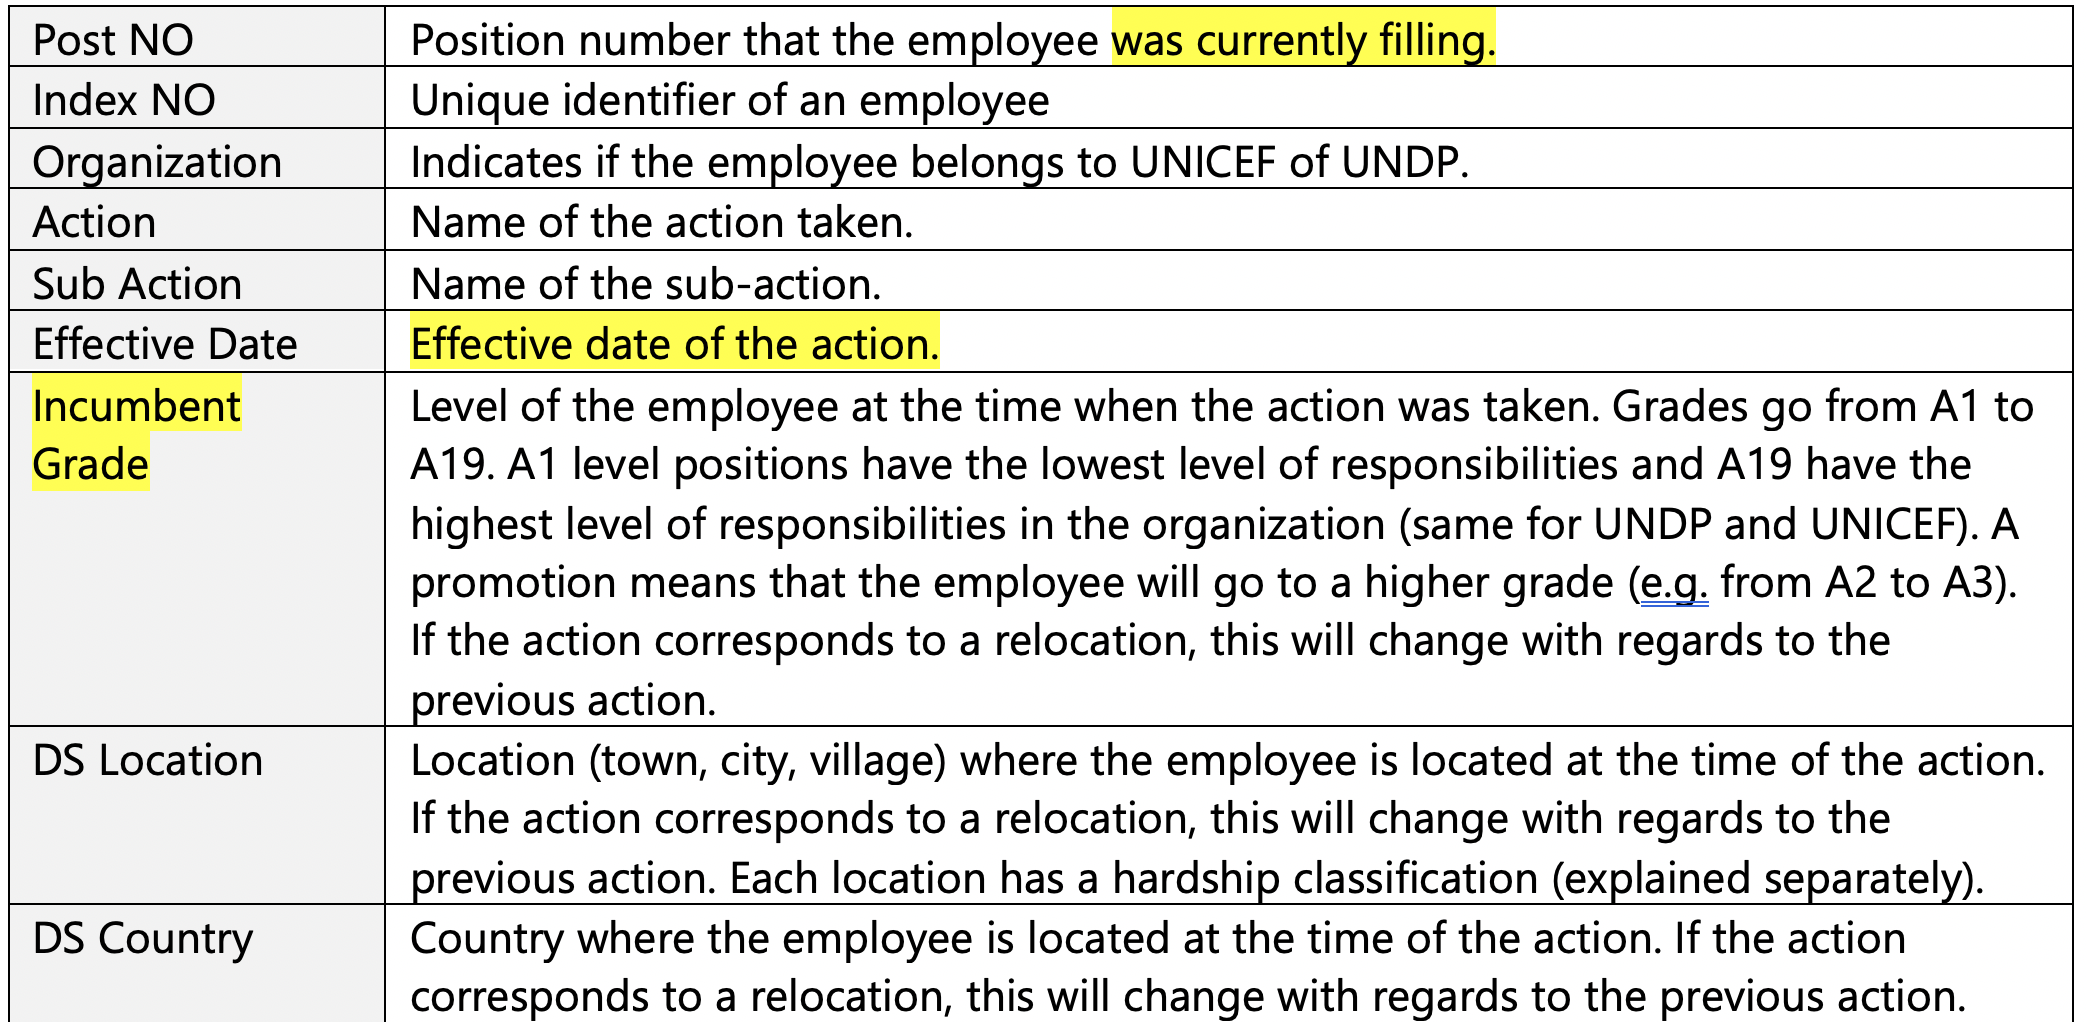

In [230]:
action = pd.read_csv('Employee_Actions.txt', sep='\t', encoding='latin1', dtype='unicode') #index_col=0,
action = action.iloc[:, :-1]

In [231]:
# Drop duplicates in Action data
action1 = action.drop_duplicates(subset = None, keep='first')
action1.head()

,Post No,Index No,Organization,Action,Sub Action,Effective Date,Incumbent Grade,DS Location,DS Country
0,SSSXAFRX,SFKFDO,UNDP,Data Change,Contract Extension,2015-02-17,A17,Yerevan,Armenia
1,SSSXAFRX,SFKFDO,UNDP,Data Change,Contract Extension,2017-02-17,A17,Yerevan,Armenia
2,SSSXAFRX,SFKFDO,UNDP,Data Change,IP Comp Review ? Step Matching,2017-01-01,A17,Yerevan,Armenia
3,SSSXAFRX,SFKFDO,UNDP,Family Status Change,Change/Add Dependent,2014-01-01,A17,Yerevan,Armenia
4,SSSXAFRX,SFKFDO,UNDP,Family Status Change,Change/Add Dependent,2016-05-20,A17,Yerevan,Armenia


In [232]:
action1.Action.nunique()

58

In [233]:
# Variable of interest: 'Promotion'
promotion = action1[action1.Action == 'Promotion']
promotion['Sub Action'].value_counts()

Promotion                         6082
Promotion - Rank in Post          2799
Unknown                            146
Noncompetitive Career Promotio      41
Name: Sub Action, dtype: int64

In [234]:
# The number of people with promotion
len(promotion['Index No'].unique())

7644

In [235]:
len(employee1) + len(action1)

688186

In [236]:
# Join employee1 + action1
employee_and_action = pd.merge(employee1, action1, how='left', on=['Index No','Post No', 'Organization'])

In [237]:
employee_and_action.isna().sum()

Post No               0
Index No              0
Organization          0
Gender                0
Nationality           0
Hire Date             0
Yrs Of Service        0
Age Group             0
Age_mean              0
Action             2083
Sub Action         2030
Effective Date     2030
Incumbent Grade    2031
DS Location        2031
DS Country         2035
dtype: int64

In [238]:
# drop NA
employee_and_action.dropna(inplace = True)

In [239]:
# Change to Datetime object
employee_and_action['Effective Date'] = pd.to_datetime(employee_and_action['Effective Date'], errors='coerce').dt.strftime('%Y-%m-%d')
employee_and_action['Effective Date'] = pd.to_datetime(employee_and_action['Effective Date'], errors='coerce')

In [240]:
print('Number of unique employee')
print('After Merge: ' + str(len(employee_and_action['Index No'].unique())))
print('In Employee Demographic data: ' + str(len(employee1['Index No'].unique())))
print('In Action data: ' + str(len(action1['Index No'].unique())))

Number of unique employee
After Merge: 46618
In Employee Demographic data: 48298
In Action data: 48732


## Data 3: Location
- variable of interest: hardship classification


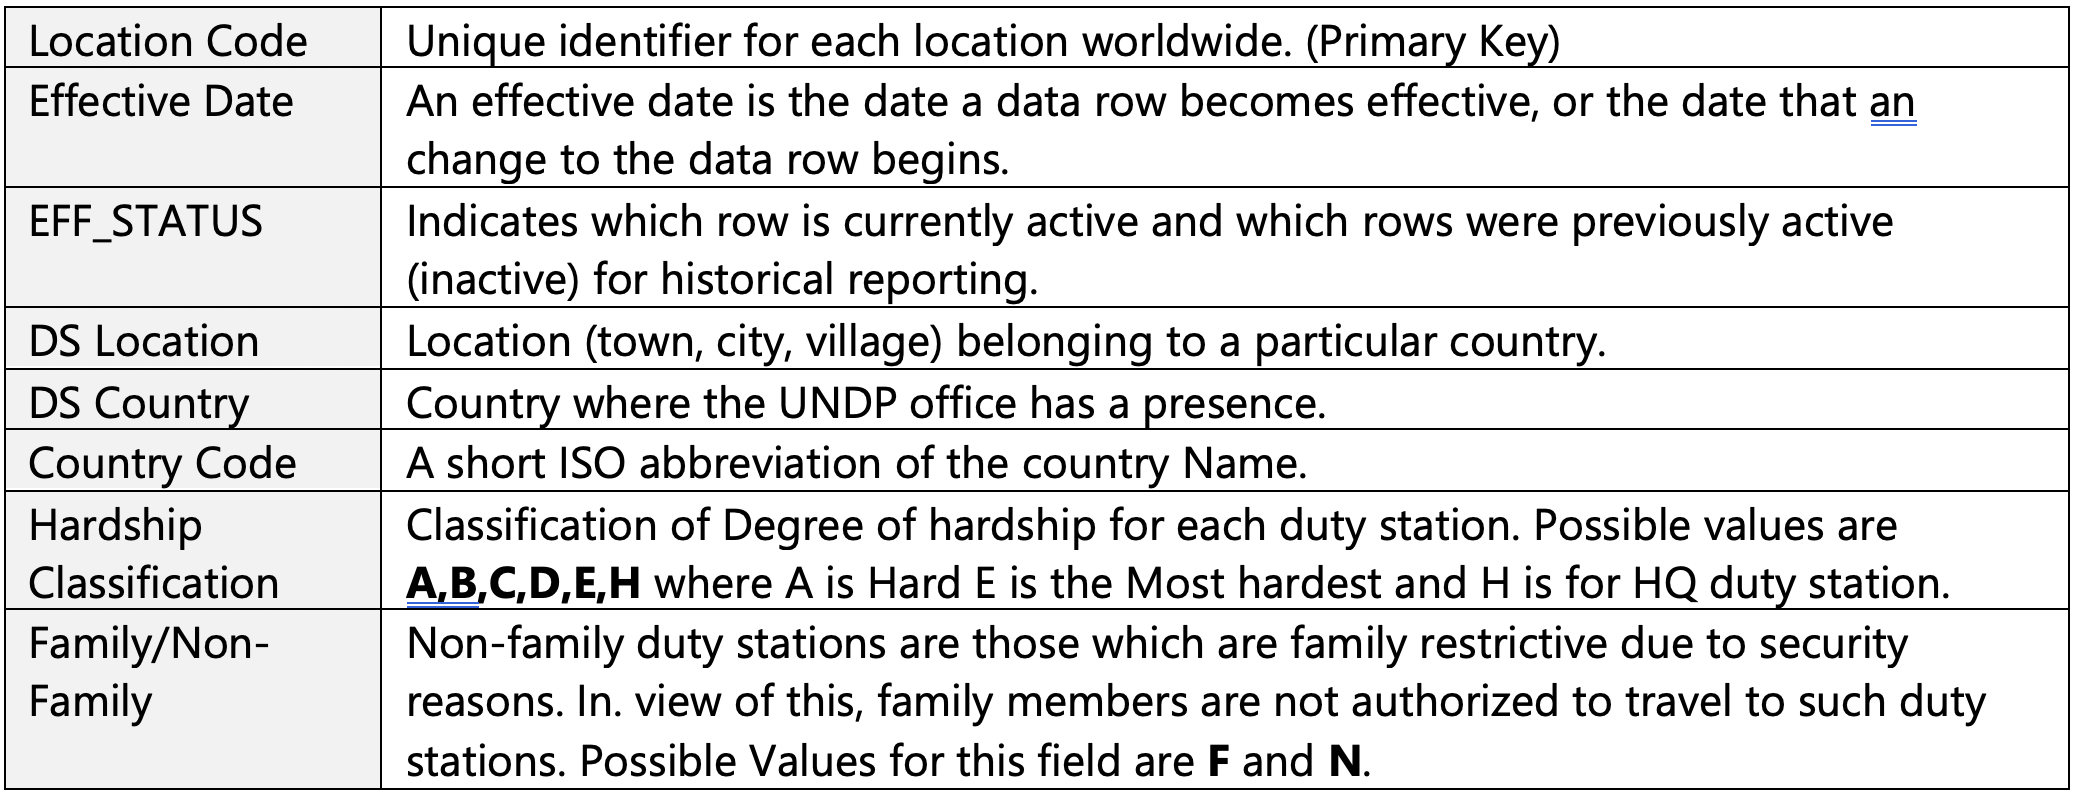

In [241]:
location = pd.read_excel('Location.xlsx')

In [242]:
location.head()

,Location Code,EffDt,Eff_Status,DS Location,DS Country,Country Code,Hardship Classification,Family/Non-Family
0,0060,24.10.1946,A,Kabul,Afghanistan,AFG,E,N
1,0060,01.01.1901,A,Kabul,Afghanistan,AFG,A,F
2,0060,01.01.2007,A,Kabul,Afghanistan,AFG,E,N
3,0060,20.02.2009,A,Kabul,Afghanistan,AFG,E,N
4,0060,01.10.2008,A,Kabul,Afghanistan,AFG,E,N


In [243]:
# Hardship Classification varies depending on datetime

location[location['DS Country'] == 'Armenia']

,Location Code,EffDt,Eff_Status,DS Location,DS Country,Country Code,Hardship Classification,Family/Non-Family
298,0260,01.01.2013,A,Yerevan,Armenia,ARM,B,F
299,0260,01.01.1901,A,Yerevan,Armenia,ARM,A,F
300,0260,01.01.2016,A,Yerevan,Armenia,ARM,A,F
301,0260,01.01.2010,A,Yerevan,Armenia,ARM,C,F
302,0260,01.01.2007,A,Yerevan,Armenia,ARM,D,F
303,0260,01.07.2016,A,Yerevan,Armenia,ARM,A,F
304,0260,01.01.1998,A,Yerevan,Armenia,ARM,D,F


In [244]:
# Make EffDt as Year_month in order to join with existing dataset: 'join'
location['EffDt'] = pd.to_datetime(location['EffDt']).dt.strftime('%d-%m-%Y')
location['EffDt'] = pd.to_datetime(location['EffDt']).dt.strftime('%Y-%m-%d')
location['EffDt'] = pd.to_datetime(location['EffDt'])
#location['Year_month'] = pd.to_datetime(location['EffDt']).dt.strftime('%Y-%m')

In [245]:
# Drop NA
employee_and_action.dropna(inplace = True)

In [246]:
# Use merge_asof function, as the two datasets do not have the exact same date information. 
# Match when location date (EffDt) is earlier than action date (Effective Date)
asof = pd.merge_asof(employee_and_action.sort_values('Effective Date'), location.sort_values('EffDt'), left_on= 'Effective Date',right_on = 'EffDt', by =['DS Location','DS Country'])

In [247]:
asof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557455 entries, 0 to 557454
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Post No                  557455 non-null  object        
 1   Index No                 557455 non-null  object        
 2   Organization             557455 non-null  object        
 3   Gender                   557455 non-null  object        
 4   Nationality              557455 non-null  object        
 5   Hire Date                557455 non-null  datetime64[ns]
 6   Yrs Of Service           557455 non-null  int64         
 7   Age Group                557455 non-null  object        
 8   Age_mean                 557455 non-null  float64       
 9   Action                   557455 non-null  object        
 10  Sub Action               557455 non-null  object        
 11  Effective Date           557455 non-null  datetime64[ns]
 12  Incumbent Grade 

In [248]:
# drop NA, caused by joining datasets.
asof.dropna(inplace = True)

In [249]:
asof.sort_values('Index No').sort_values(by=['Index No','Effective Date','Action','Sub Action']).head(10).T

,330522,341306,351658,361315,371187,373107,377332,425703,427731,463130
Post No,PXRRS,PXRRS,PXRRS,PXRRS,PXRRS,PZOFS,PZOFS,PZOFS,PZOFS,PZOFS
Index No,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ
Organization,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF
Gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
Nationality,Equatorial Guinea,Equatorial Guinea,Equatorial Guinea,Equatorial Guinea,Equatorial Guinea,Equatorial Guin,Equatorial Guin,Equatorial Guin,Equatorial Guin,Equatorial Guin
Hire Date,2015-04-15 00:00:00,2015-04-15 00:00:00,2015-04-15 00:00:00,2015-04-15 00:00:00,2015-04-15 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00
Yrs Of Service,5,5,5,5,5,4,4,4,4,4
Age Group,20-29,20-29,20-29,20-29,20-29,30-39,30-39,30-39,30-39,30-39
Age_mean,24.5,24.5,24.5,24.5,24.5,34.5,34.5,34.5,34.5,34.5
Action,Initial appointment,Contract Change,Contract Change,Contract Change,Separation,Reappointment,Change in Pay,Change in Pay,Create Fam Member/Dependents,Contract Change


In [250]:
asof['Hardship Classification'].value_counts()

A    115677
B     88523
C     80062
H     59374
E     59332
D     55678
         17
Name: Hardship Classification, dtype: int64

In [251]:
# Change column names
asof = asof.rename(columns = {'Post No':'Current_Position'})

In [252]:
asof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458663 entries, 0 to 557441
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Current_Position         458663 non-null  object        
 1   Index No                 458663 non-null  object        
 2   Organization             458663 non-null  object        
 3   Gender                   458663 non-null  object        
 4   Nationality              458663 non-null  object        
 5   Hire Date                458663 non-null  datetime64[ns]
 6   Yrs Of Service           458663 non-null  int64         
 7   Age Group                458663 non-null  object        
 8   Age_mean                 458663 non-null  float64       
 9   Action                   458663 non-null  object        
 10  Sub Action               458663 non-null  object        
 11  Effective Date           458663 non-null  datetime64[ns]
 12  Incumbent Grade 

In [253]:
# Finished joining 3 datasets: demographics + actions + location
# Selected columns needed.
df = asof.drop(['Location Code', 'EffDt','Age Group','Eff_Status','Country Code','Sub Action'], axis = 1)
df.head()

,Current_Position,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age_mean,Action,Effective Date,Incumbent Grade,DS Location,DS Country,Hardship Classification,Family/Non-Family
0,SSSSDOXZ,DDXKP,UNDP,Male,Unknown,1954-01-01,66,94.5,Hire,1954-01-01,A3,Baghdad,Iraq,A,F
1,SSSSDOXZ,KDZODK,UNDP,Male,Unknown,1963-10-01,56,94.5,Retirement,1963-10-01,A2,Algiers,Algeria,A,F
2,SSSSDOXZ,KDZODK,UNDP,Male,Unknown,1963-10-01,56,94.5,Hire,1963-10-01,A2,Algiers,Algeria,A,F
3,SSSSDOXZ,XSFKXP,UNDP,Female,Unknown,1963-12-04,56,84.5,Hire,1963-12-04,A7,Baghdad,Iraq,A,F
4,SSSSDOXZ,KAXFDR,UNDP,Female,Unknown,1964-01-01,56,84.5,Hire,1964-01-01,A6,Nicosia,Cyprus,A,F


### Creat New Columns

- 1) the total number of positions they've been in so far.
- 2) Yrs of Service: select the longest one
- 3) Age: select the latest age
- 4) Assign numerical values in Hardship Classification, calculate min, median, max.
- 5) Assign numerical values in Incumbent Grade, calculate min, max.


### 1) Calculate the total number of positions that each individual has been in so far

In [254]:
df['Position_Count'] = df.groupby(['Index No'])['Current_Position'].transform('nunique')
df.sort_values(['Index No', 'Current_Position']).head(10)

,Current_Position,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age_mean,Action,Effective Date,Incumbent Grade,DS Location,DS Country,Hardship Classification,Family/Non-Family,Position_Count
330522,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Initial appointment,2015-04-15,A2,Bata,Equatorial Guinea,D,F,2
341306,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Contract Change,2015-07-15,A2,Bata,Equatorial Guinea,D,F,2
351658,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Contract Change,2015-10-15,A2,Bata,Equatorial Guinea,D,F,2
361315,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Contract Change,2016-01-01,A2,Bata,Equatorial Guinea,D,F,2
371187,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Separation,2016-02-01,A2,Bata,Equatorial Guinea,D,F,2
373107,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Reappointment,2016-03-01,A2,Bata,Equatorial Guinea,D,F,2
377332,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2016-04-01,A2,Bata,Equatorial Guinea,D,F,2
425703,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2017-03-01,A2,Bata,Equatorial Guinea,D,F,2
427731,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Create Fam Member/Dependents,2017-03-10,A2,Bata,Equatorial Guinea,D,F,2
463130,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Contract Change,2018-01-01,A2,Bata,Equatorial Guinea,D,F,2


### 2) Select the longest Yrs of Service, by individual

In [255]:
df['Years of Service'] = df.groupby(['Index No'])['Yrs Of Service'].transform(max)

df.sort_values(['Index No']).head()

,Current_Position,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age_mean,Action,Effective Date,Incumbent Grade,DS Location,DS Country,Hardship Classification,Family/Non-Family,Position_Count,Years of Service
330522,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Initial appointment,2015-04-15,A2,Bata,Equatorial Guinea,D,F,2,5
371187,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Separation,2016-02-01,A2,Bata,Equatorial Guinea,D,F,2,5
476515,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2018-03-01,A2,Bata,Equatorial Guinea,D,F,2,5
525573,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2019-03-01,A2,Bata,Equatorial Guinea,D,F,2,5
425703,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2017-03-01,A2,Bata,Equatorial Guinea,D,F,2,5


### 3) Select the latest age, by individual

In [256]:
df['Age'] = df.groupby(['Index No'])['Age_mean'].transform(max)

df.sort_values(['Index No']).head()

,Current_Position,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age_mean,Action,Effective Date,Incumbent Grade,DS Location,DS Country,Hardship Classification,Family/Non-Family,Position_Count,Years of Service,Age
330522,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Initial appointment,2015-04-15,A2,Bata,Equatorial Guinea,D,F,2,5,34.5
371187,PXRRS,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,5,24.5,Separation,2016-02-01,A2,Bata,Equatorial Guinea,D,F,2,5,34.5
476515,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2018-03-01,A2,Bata,Equatorial Guinea,D,F,2,5,34.5
525573,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2019-03-01,A2,Bata,Equatorial Guinea,D,F,2,5,34.5
425703,PZOFS,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,4,34.5,Change in Pay,2017-03-01,A2,Bata,Equatorial Guinea,D,F,2,5,34.5


### 4) Re-organize Hardship Classification --> to numerical values

Hardship Classification: A,B,C,D,E,H where A is Hard, E is the Most hardest, and H is for HQ duty station

In [257]:
df['Hardship Classification'].unique()

array(['A', 'B', 'E', 'H', 'C', 'D', ' '], dtype=object)

In [258]:
# delete rows with unclassified Hardship Classification
df = df[df['Hardship Classification']!=' ']

In [259]:
df['Hardship Classification'].unique()

array(['A', 'B', 'E', 'H', 'C', 'D'], dtype=object)

In [260]:
# Hardship Classification: A,B,C,D,E,H where A is Hard, E is the Most hardest, and H is for HQ duty station

hardship_level = {'H': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}

df['New Hardship Classification'] = df['Hardship Classification'].replace(hardship_level)
df.head()

# New Hardship Classification is now ordinal variable. 

,Current_Position,Index No,Organization,Gender,Nationality,Hire Date,Yrs Of Service,Age_mean,Action,Effective Date,Incumbent Grade,DS Location,DS Country,Hardship Classification,Family/Non-Family,Position_Count,Years of Service,Age,New Hardship Classification
0,SSSSDOXZ,DDXKP,UNDP,Male,Unknown,1954-01-01,66,94.5,Hire,1954-01-01,A3,Baghdad,Iraq,A,F,1,66,94.5,1
1,SSSSDOXZ,KDZODK,UNDP,Male,Unknown,1963-10-01,56,94.5,Retirement,1963-10-01,A2,Algiers,Algeria,A,F,1,56,94.5,1
2,SSSSDOXZ,KDZODK,UNDP,Male,Unknown,1963-10-01,56,94.5,Hire,1963-10-01,A2,Algiers,Algeria,A,F,1,56,94.5,1
3,SSSSDOXZ,XSFKXP,UNDP,Female,Unknown,1963-12-04,56,84.5,Hire,1963-12-04,A7,Baghdad,Iraq,A,F,1,56,84.5,1
4,SSSSDOXZ,KAXFDR,UNDP,Female,Unknown,1964-01-01,56,84.5,Hire,1964-01-01,A6,Nicosia,Cyprus,A,F,1,56,84.5,1


### 4-1) Re-organize Hardship Classification --> to numerical values --> calculate min, median, max of Hardship Classification, by individual

encoding: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

In [261]:
df['New Hardship Classification'] = df['New Hardship Classification'].apply(lambda x: float(x))

In [262]:
# Calculate each individual's 25, 50, 75% quantile of Hardship Classification
df['Hardship_min'] = df.groupby(['Index No'])['New Hardship Classification'].transform(min)
df['Hardship_median'] = df.groupby(['Index No'])['New Hardship Classification'].transform('median')
df['Hardship_max'] = df.groupby(['Index No'])['New Hardship Classification'].transform(max)

### 4-3) Ordinal Encoding for Incumbent Grade --> Min & Max : to see how far have they been promoted during years of service in UN

- Incumbent Grade: Level of the employee at the time when the action was taken. Grades go from A1 to A19. A1 level positions have the lowest level of responsibilities and A19 have the highest level of responsibilities in the organization

In [263]:
# Drop 'Not coded'&' ', 60 in total

df = df[(df['Incumbent Grade'] != 'Not coded') & (df['Incumbent Grade'] != ' ')]

In [264]:
incumbent_levels = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4,'A5': 5, 'A6': 6, 'A7': 7, 'A8': 8,
                    'A9': 9, 'A10': 10, 'A11': 11, 'A12': 12,'A13': 13, 'A14': 14, 'A15': 15, 'A16': 16,
                    'A17': 17, 'A18': 18, 'A19': 19}

In [265]:
df['New Incumbent Grade'] = df['Incumbent Grade'].map(incumbent_levels)

In [266]:
df['Min_Incumbent'] = df.groupby(['Index No'])['New Incumbent Grade'].transform(min)
df['Max_Incumbent'] = df.groupby(['Index No'])['New Incumbent Grade'].transform(max)

In [267]:
df.sort_values(by = 'Index No').head(30).T

,330522,427731,351658,341306,371187,463130,377332,425703,525573,373107,...,181916,196498,245871,313711,238609,430913,238598,117565,495540,297407
Current_Position,PXRRS,PZOFS,PXRRS,PXRRS,PXRRS,PZOFS,PZOFS,PZOFS,PZOFS,PZOFS,...,AFZXD,AFZXD,AFZXD,AFZXD,AFZXD,SSZSRZSX,AFZXD,FPDAA,RZRAX,DZASF
Index No,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,AAAAAZ,...,AAADFF,AAADFF,AAADFF,AAADFF,AAADFF,AAADFF,AAADFF,AAADK,AAADK,AAADK
Organization,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,...,UNICEF,UNICEF,UNICEF,UNICEF,UNICEF,UNDP,UNICEF,UNICEF,UNICEF,UNICEF
Gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,...,Male,Male,Male,Male,Male,Male,Male,Female,Female,Female
Nationality,Equatorial Guinea,Equatorial Guin,Equatorial Guinea,Equatorial Guinea,Equatorial Guinea,Equatorial Guin,Equatorial Guin,Equatorial Guin,Equatorial Guin,Equatorial Guin,...,Kenya,Kenya,Kenya,Kenya,Kenya,Kenya,Kenya,Cote d'Ivoire,Cote d'Ivoire,Cote d'Ivoire
Hire Date,2015-04-15 00:00:00,2016-03-01 00:00:00,2015-04-15 00:00:00,2015-04-15 00:00:00,2015-04-15 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,2016-03-01 00:00:00,...,2011-05-01 00:00:00,2011-05-01 00:00:00,2011-05-01 00:00:00,2011-05-01 00:00:00,2011-05-01 00:00:00,2008-11-10 00:00:00,2011-05-01 00:00:00,2009-08-24 00:00:00,2009-08-24 00:00:00,2009-08-24 00:00:00
Yrs Of Service,5,4,5,5,5,4,4,4,4,4,...,9,9,9,9,9,11,9,11,11,11
Age_mean,24.5,34.5,24.5,24.5,24.5,34.5,34.5,34.5,34.5,34.5,...,34.5,34.5,34.5,34.5,34.5,44.5,34.5,34.5,44.5,44.5
Action,Initial appointment,Create Fam Member/Dependents,Contract Change,Contract Change,Separation,Contract Change,Change in Pay,Change in Pay,Change in Pay,Reappointment,...,HR Conversion,Change in Pay,Organizational Mgmt Change,Contract Change,Contract Change,Separation,Change in Pay,Unknown,Change in Pay,M&HA
Effective Date,2015-04-15 00:00:00,2017-03-10 00:00:00,2015-10-15 00:00:00,2015-07-15 00:00:00,2016-02-01 00:00:00,2018-01-01 00:00:00,2016-04-01 00:00:00,2017-03-01 00:00:00,2019-03-01 00:00:00,2016-03-01 00:00:00,...,2012-01-01 00:00:00,2012-05-01 00:00:00,2013-07-01 00:00:00,2015-01-01 00:00:00,2013-05-01 00:00:00,2017-04-07 00:00:00,2013-05-01 00:00:00,2010-08-24 00:00:00,2018-08-01 00:00:00,2014-08-24 00:00:00


### 5) Make Actions dummy

In [268]:
df1 = df.drop(['Incumbent Grade','Yrs Of Service','Age_mean','New Incumbent Grade','Current_Position', 'Hardship Classification','New Hardship Classification','Effective Date'], axis = 1)
df1.sort_values(by ='Index No').head()

,Index No,Organization,Gender,Nationality,Hire Date,Action,DS Location,DS Country,Family/Non-Family,Position_Count,Years of Service,Age,Hardship_min,Hardship_median,Hardship_max,Min_Incumbent,Max_Incumbent
330522,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Initial appointment,Bata,Equatorial Guinea,F,2,5,34.5,4.0,4.0,4.0,2,2
427731,AAAAAZ,UNICEF,Male,Equatorial Guin,2016-03-01,Create Fam Member/Dependents,Bata,Equatorial Guinea,F,2,5,34.5,4.0,4.0,4.0,2,2
351658,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Contract Change,Bata,Equatorial Guinea,F,2,5,34.5,4.0,4.0,4.0,2,2
341306,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Contract Change,Bata,Equatorial Guinea,F,2,5,34.5,4.0,4.0,4.0,2,2
371187,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Separation,Bata,Equatorial Guinea,F,2,5,34.5,4.0,4.0,4.0,2,2


In [269]:
# Make dummy for Action column
dummy = pd.get_dummies(df1['Action'])
dummy.head()

,Add Contingent Worker,Additional Job,CSL Half Pay Only,Category Change,Change Employment Percentage,Change Personal Data,Change in Grade,Change in Pay,Contract Change,Correct Staff Birth Date,...,Return from temp Assignment,Separation,Suspension,Temp Assignment,Termination,Transfer,Travel for Appointment,Travel for Re-Appointment,Unknown,Update(Local Staff)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
# Concat with the original data
newdf = pd.concat([df1, dummy], axis = 1)
newdf = newdf.drop(['Action'], axis = 1)
newdf.head()

,Index No,Organization,Gender,Nationality,Hire Date,DS Location,DS Country,Family/Non-Family,Position_Count,Years of Service,...,Return from temp Assignment,Separation,Suspension,Temp Assignment,Termination,Transfer,Travel for Appointment,Travel for Re-Appointment,Unknown,Update(Local Staff)
0,DDXKP,UNDP,Male,Unknown,1954-01-01,Baghdad,Iraq,F,1,66,...,0,0,0,0,0,0,0,0,0,0
1,KDZODK,UNDP,Male,Unknown,1963-10-01,Algiers,Algeria,F,1,56,...,0,0,0,0,0,0,0,0,0,0
2,KDZODK,UNDP,Male,Unknown,1963-10-01,Algiers,Algeria,F,1,56,...,0,0,0,0,0,0,0,0,0,0
3,XSFKXP,UNDP,Female,Unknown,1963-12-04,Baghdad,Iraq,F,1,56,...,0,0,0,0,0,0,0,0,0,0
4,KAXFDR,UNDP,Female,Unknown,1964-01-01,Nicosia,Cyprus,F,1,56,...,0,0,0,0,0,0,0,0,0,0


### 5-1) Groupby 'Index No' and count the sum of each action, to make "one individual per row"

In [271]:
dummy_column_list = list(dummy.columns)

In [272]:
newdf[dummy_column_list] = newdf.groupby(['Index No'])[dummy.columns].transform(sum)

In [273]:
newdf1 = newdf.sort_values(['Index No','Hire Date'])

In [274]:
newdf1.head()

,Index No,Organization,Gender,Nationality,Hire Date,DS Location,DS Country,Family/Non-Family,Position_Count,Years of Service,...,Return from temp Assignment,Separation,Suspension,Temp Assignment,Termination,Transfer,Travel for Appointment,Travel for Re-Appointment,Unknown,Update(Local Staff)
330522,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Bata,Equatorial Guinea,F,2,5,...,0,1,0,0,0,0,0,0,0,0
341306,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Bata,Equatorial Guinea,F,2,5,...,0,1,0,0,0,0,0,0,0,0
351658,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Bata,Equatorial Guinea,F,2,5,...,0,1,0,0,0,0,0,0,0,0
361315,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Bata,Equatorial Guinea,F,2,5,...,0,1,0,0,0,0,0,0,0,0
371187,AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Bata,Equatorial Guinea,F,2,5,...,0,1,0,0,0,0,0,0,0,0


### 5-2) Select the first row of each individual to stop repetition.

unique 'Index No' at the original employee demographic data was about 50000(demo), but now it's 38949(demo+action+location)

In [275]:
# Since we have the same information over the multiple rows of each individual, let's select just the first row of each individual.
newdf2 = newdf1.groupby('Index No').first()
newdf2.head()

,Organization,Gender,Nationality,Hire Date,DS Location,DS Country,Family/Non-Family,Position_Count,Years of Service,Age,...,Return from temp Assignment,Separation,Suspension,Temp Assignment,Termination,Transfer,Travel for Appointment,Travel for Re-Appointment,Unknown,Update(Local Staff)
Index No,,,,,,,,,,,,,,,,,,,,,
AAAAAZ,UNICEF,Male,Equatorial Guinea,2015-04-15,Bata,Equatorial Guinea,F,2,5,34.5,...,0,1,0,0,0,0,0,0,0,0
AAAAOX,UNDP,Female,Unknown,2007-09-17,Kingston,Jamaica,F,1,12,54.5,...,0,0,0,0,1,0,0,0,0,0
AAADFF,UNDP,Male,Kenya,2008-11-10,Freetown,Sierra Leone,F,2,11,44.5,...,0,2,0,0,0,0,0,0,0,0
AAADK,UNICEF,Female,Cote d'Ivoire,2009-08-24,Man,Cote D'Ivoire,N,4,11,44.5,...,0,0,0,0,0,0,0,0,2,0
AAADKS,UNICEF,Male,Zimbabwe,2015-04-10,Harare,Zimbabwe,F,1,5,44.5,...,0,1,0,0,0,0,0,0,0,0


In [276]:
newdf2.reset_index(inplace=True)

Now the data is 'one person per row', including Demographics + Action + Location datasets

In [277]:
newdf2.columns

Index(['Index No', 'Organization', 'Gender', 'Nationality', 'Hire Date',
       'DS Location', 'DS Country', 'Family/Non-Family', 'Position_Count',
       'Years of Service', 'Age', 'Hardship_min', 'Hardship_median',
       'Hardship_max', 'Min_Incumbent', 'Max_Incumbent',
       'Add Contingent Worker', 'Additional Job', 'CSL Half Pay Only',
       'Category Change', 'Change Employment Percentage',
       'Change Personal Data', 'Change in Grade', 'Change in Pay',
       'Contract Change', 'Correct Staff Birth Date',
       'Correct staff birth date', 'Corrected Entry Date',
       'Create Fam Member/Dependents', 'Data Change', 'Demotion',
       'Double Incumbency', 'Entry into UNJSPF', 'Family Status Change',
       'Grant Maternity/Paternity Leav', 'HR Conversion', 'Hire',
       'Incorrect Entry Date', 'Initial Appt - Pernr exist',
       'Initial appointment', 'Lateral Move', 'Lateral Move - Loan',
       'Leave of Absence', 'Local Transfer to SAP', 'Long Term Absence',
       'L

In [278]:
newdf2.shape

(38949, 73)

## Data 4: Performance (Target Variable)
- 1) Change the performance rating into numerical values
- 2) Some staffs received performance evaluation for four years, but some only received for one or two years. So I calculated the mean of performance rating for each individual
- 3) Get first row of each individual to stop repetition
- 4) Join Performance data, based on 'Index No'

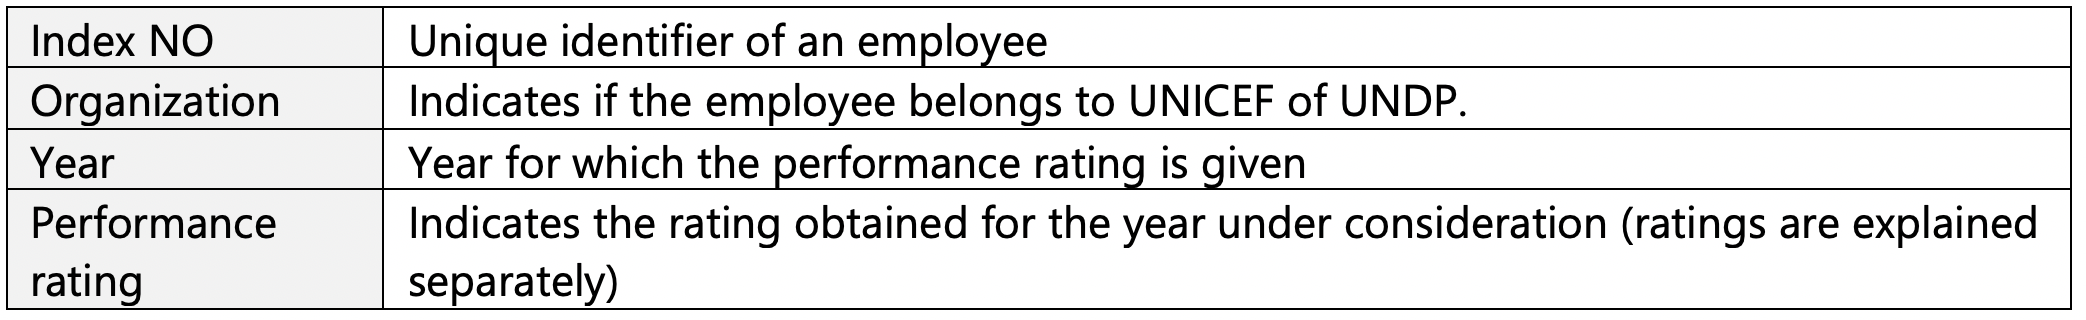

In [279]:
performance = pd.read_csv('Performance.txt', sep=",", names= ['Index No','Organization','Year','Performance Rating'])
performance = performance.iloc[1: , :]
performance.sort_values('Index No').head()

,Index No,Organization,Year,Performance Rating
12477,AAAAAR,UNICEF,2017,Solid Achievement
25502,AAAAAR,UNICEF,2016,Solid Achievement
12478,AAAAAR,UNICEF,2018,Solid Achievement
16154,AAAAAZ,UNICEF,2018,Solid Achievement
12476,AAAAAZ,UNICEF,2017,Outstanding Achievement


In [280]:
performance.Year.unique()

array(['2018', '2016', '2017', '2019'], dtype=object)

In [281]:
performance['Performance Rating'].unique()

array(['Solid Achievement', 'Successful PLUS performance',
       'Outstanding Achievement', 'Successful performance', nan,
       'Partially successful performance', 'Low Achievement',
       'Performance below standards'], dtype=object)

In [282]:
performance['Performance Rating'].value_counts()

Solid Achievement                   27839
Successful performance               6122
Outstanding Achievement              5774
Successful PLUS performance          3241
Low Achievement                       325
Partially successful performance      186
Performance below standards            18
Name: Performance Rating, dtype: int64

In [283]:
performance.shape

(44266, 4)

In [284]:
NA_performance = pd.DataFrame(performance.isna().sum())
NA_performance.rename(columns={0: "NA"})

,NA
Index No,0
Organization,0
Year,0
Performance Rating,761


In [285]:
# Delete rows with NA in 'Performance Rating'.
performance1 = performance[~performance['Performance Rating'].isna()] 
performance1

,Index No,Organization,Year,Performance Rating
1,SSDFZF,UNICEF,2018,Solid Achievement
2,SSDFDP,UNICEF,2016,Solid Achievement
3,SSDOXR,UNDP,2017,Successful PLUS performance
4,SSDXFD,UNICEF,2016,Solid Achievement
5,SSDXKK,UNICEF,2017,Solid Achievement
...,...,...,...,...
44261,NZZZZFRAKF,UNDP,2017,Partially successful performance
44262,NZZZZFRAKF,UNDP,2018,Successful performance
44263,NZZZZFKOFP,UNDP,2017,Successful performance
44264,NZZZZFKOFP,UNDP,2018,Successful PLUS performance


In [286]:
# re-label Performance Rating with numeric values

performance_level = {'Performance below standards':0,'Low Achievement':1,
                     'Partially successful performance':2, 'Solid Achievement':3, 
                     'Successful performance':4, 'Successful PLUS performance':4,
                    'Outstanding Achievement':5}


performance1['New Performance Rating'] = performance1['Performance Rating'].replace(performance_level)  
    
performance1.sort_values('Index No').head(10)

,Index No,Organization,Year,Performance Rating,New Performance Rating
12477,AAAAAR,UNICEF,2017,Solid Achievement,3
12478,AAAAAR,UNICEF,2018,Solid Achievement,3
25502,AAAAAR,UNICEF,2016,Solid Achievement,3
17210,AAAAAZ,UNICEF,2016,Solid Achievement,3
12476,AAAAAZ,UNICEF,2017,Outstanding Achievement,5
16154,AAAAAZ,UNICEF,2018,Solid Achievement,3
12470,AAADDA,UNICEF,2017,Outstanding Achievement,5
12471,AAADDA,UNICEF,2018,Outstanding Achievement,5
25495,AAADDA,UNICEF,2016,Outstanding Achievement,5
17208,AAADK,UNICEF,2017,Solid Achievement,3


In [287]:
performance1['Performance_mean'] = performance1.groupby(['Index No'])['New Performance Rating'].transform('median').astype('int')

In [288]:
performance1.drop(['Year','Performance Rating','New Performance Rating','Organization'], axis=1, inplace=True)

In [289]:
performance1.sort_values(by='Index No')

,Index No,Performance_mean
12477,AAAAAR,3
12478,AAAAAR,3
25502,AAAAAR,3
17210,AAAAAZ,3
12476,AAAAAZ,3
...,...,...
37872,XZZZKD,3
37873,XZZZOD,3
28252,XZZZOD,3
36134,XZZZSP,4


In [290]:
performance1 = performance1.groupby('Index No').first()
performance1 = performance1.reset_index()

In [292]:
# We have 19144 rows in performance dataset. (in the demographic data, the number of employees: 50000)

print(newdf2.shape)
print(performance1.shape)

(38949, 73)
(19144, 2)


In [293]:
# Join newdf2(employee+action+location) + performance3
# We will lose lots of rows when joining, because performance data only have 19144 people's information

d = pd.merge(newdf2, performance1, how = 'left', on='Index No')

In [294]:
d.shape

(38949, 74)

In [295]:
d.isna().sum()

Index No                         0
Organization                     0
Gender                           0
Nationality                      0
Hire Date                        0
                             ...  
Travel for Appointment           0
Travel for Re-Appointment        0
Unknown                          0
Update(Local Staff)              0
Performance_mean             23859
Length: 74, dtype: int64

In [296]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38949 entries, 0 to 38948
Data columns (total 74 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Index No                        38949 non-null  object        
 1   Organization                    38949 non-null  object        
 2   Gender                          38949 non-null  object        
 3   Nationality                     38949 non-null  object        
 4   Hire Date                       38949 non-null  datetime64[ns]
 5   DS Location                     38949 non-null  object        
 6   DS Country                      38949 non-null  object        
 7   Family/Non-Family               38949 non-null  object        
 8   Position_Count                  38949 non-null  int64         
 9   Years of Service                38949 non-null  int64         
 10  Age                             38949 non-null  float64       
 11  Ha

In [297]:
# We had to drop all the other NAs in other variables, because Performance is the target variable.
finaldf = d[~d['Performance_mean'].isna()]

In [298]:
finaldf.shape

(15090, 74)

In [299]:
finaldf.to_csv('finaldf.csv', index=False)

# Exploratory data analysis

In [300]:
import matplotlib.pyplot as plt
import seaborn as sns

In [302]:
gender_groupby = finaldf.groupby(["Gender", "Performance_mean"]).agg({'Index No':'count'})
gender_groupby = pd.DataFrame(gender_groupby).reset_index()

In [303]:
gender_performance_pct = gender_groupby.groupby(['Gender', "Performance_mean"]).agg({"Index No":'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
gender_performance_pct = pd.DataFrame(gender_performance_pct).reset_index()

There is a belief that women apply to a lesser extent for jobs in hardship
locations (e.g. crisis countries) than men. However, another hypothesis states
that they do apply but that there is bias in terms of the selection process

Bearing in mind the two points above, are women being disadvantaged as soon as
we make working in a hardship location a condition for career advancement?

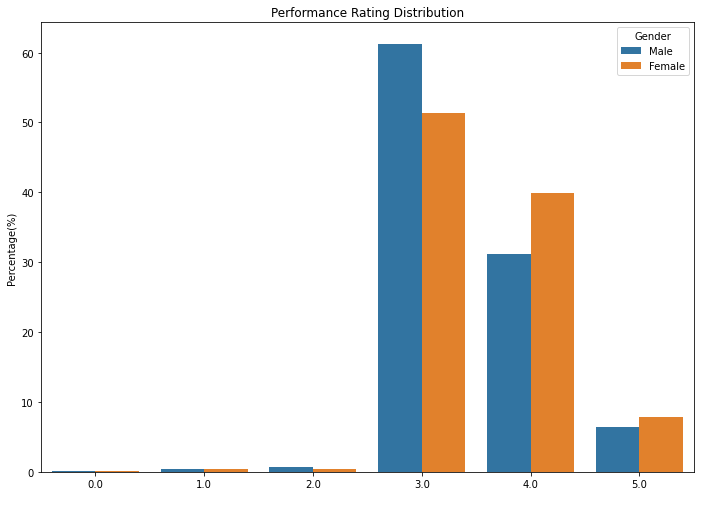

In [304]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
labels=['Male','Female']
sns.barplot(data=gender_performance_pct, x="Performance_mean", y= "Index No", hue="Gender", hue_order=labels)
plt.title('Performance Rating Distribution')
plt.xlabel(' ')
plt.ylabel('Percentage(%)')
plt.show()

In [305]:
# Make new column "Difference in incumbent grade to calculate increase in grade"
finaldf['Difference_incumbent'] = finaldf['Max_Incumbent']-finaldf['Min_Incumbent']
incumbent = finaldf[['Difference_incumbent', 'Gender']]

In [306]:
incumbent_pct = incumbent.groupby(['Gender','Difference_incumbent']).agg({"Difference_incumbent":'count'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
incumbent_pct = pd.DataFrame(incumbent_pct)
incumbent_pct = incumbent_pct.rename(columns={'Gender':'Gender','Difference_incumbent':'Difference_incumbent', 'Difference_incumbent':'Percentage'}).reset_index()
incumbent_pct = incumbent_pct.sort_values('Difference_incumbent', ascending = False)

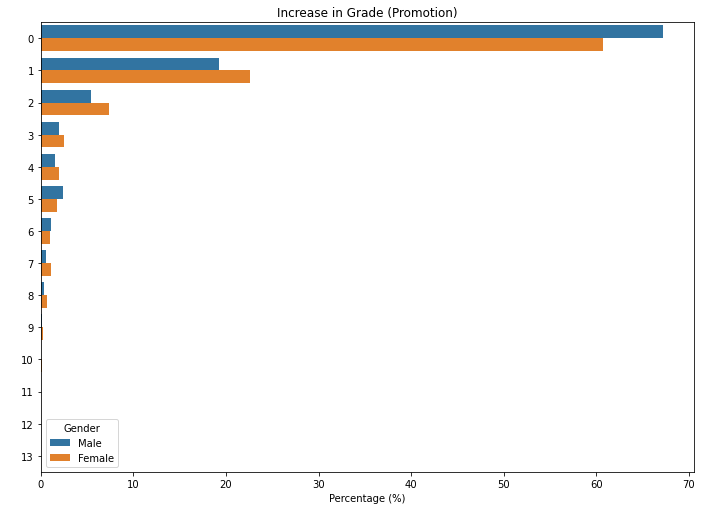

In [307]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
labels=['Male','Female']
sns.barplot(data=incumbent_pct, x='Percentage', y="Difference_incumbent", hue="Gender", hue_order=labels, orient='h')
plt.title('Increase in Grade (Promotion)')
plt.xlabel('Percentage (%)')
plt.ylabel(' ')
plt.show()

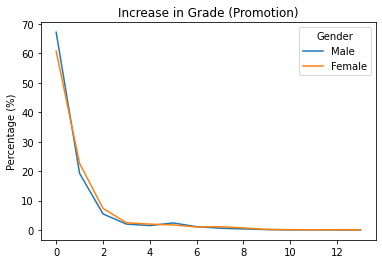

In [308]:
sns.lineplot(data=incumbent_pct, x='Difference_incumbent', y="Percentage", hue="Gender", hue_order=labels)
plt.title('Increase in Grade (Promotion)')
plt.xlabel('')
plt.ylabel('Percentage (%)')
plt.show();

In [309]:
hard_groupby = finaldf.groupby(["Gender", "Hardship_max"]).agg({'Index No':'count'})
hard_groupby = pd.DataFrame(hard_groupby).reset_index()
hard_pct = hard_groupby.groupby(['Gender', "Hardship_max"]).agg({"Index No":'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
hard_pct = pd.DataFrame(hard_pct).reset_index()

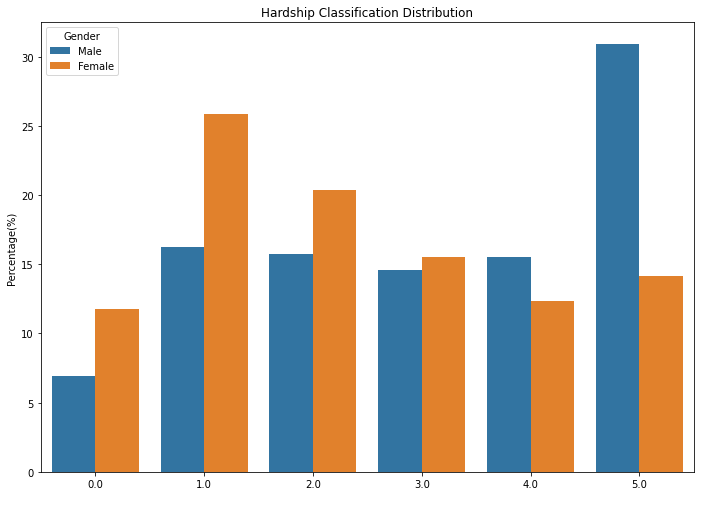

In [310]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
labels=['Male','Female']
sns.barplot(data=hard_pct, x="Hardship_max", y= "Index No", hue="Gender", hue_order=labels)
plt.title('Hardship Classification Distribution')
plt.xlabel(' ')
plt.ylabel('Percentage(%)')
plt.show()

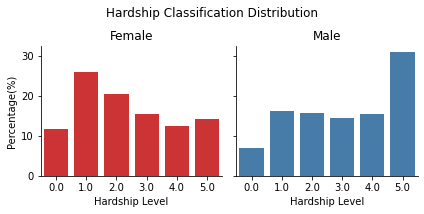

In [311]:
grid = sns.FacetGrid(data=hard_pct, col='Gender', hue='Gender', palette='Set1')
grid.map(sns.barplot, "Hardship_max", "Index No")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Hardship Classification Distribution")

axes = grid.axes.flatten()
axes[0].set_title("Female")
axes[1].set_title("Male")
axes[0].set_ylabel("Percentage(%)")
axes[0].set_xlabel("Hardship Level")
axes[1].set_xlabel("Hardship Level")
plt.show();

# Hypothesis Testing 1

One of the few existing hypotheses from the UNICEF and UNDP teams:

"A tour of duty in a hardship duty station will provide the employee with better
opportunities for promotion in their future career. UNDP encourages that staff
who want to move higher in the organization should have at least one of these
assignments during their careers."

### Does working at hardship duty station give you better chance to get higher performance score?

Test to see whether working experience in hardship duty station and performance score are dependent on each other. 

- Null hypothesis: The distribution of performance score is independent of working experience in hardship duty station

- Alternative hypothesis: There is a difference in the distribution of performance score among the different hardship classification group.

We will divide the staffs into two groups: those who have been in the hardship duty station and those who have only been in the Headquarter.
- Hardship_level = {'H': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
- A is Hard E is the Most hardest and H is for HQ duty station

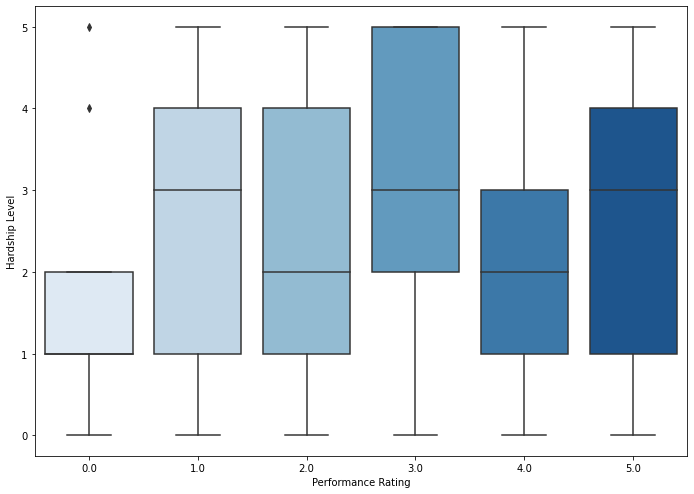

In [390]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=finaldf,
            x="Performance_mean",
            y="Hardship_max", palette="Blues")
plt.title('')
plt.xlabel('Performance Rating')
plt.ylabel('Hardship Level')
plt.suptitle('')
plt.show();

People who received 0 in performance rating have mostly been in easier locations than the other people who have higher socres. 

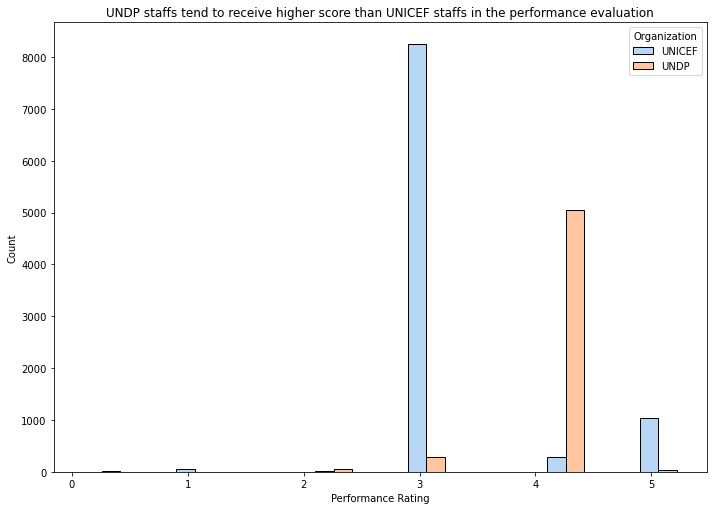

In [405]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.histplot(data=finaldf, x="Performance_mean", hue="Organization", multiple="dodge", shrink=.8, binwidth=0.4, palette="pastel")
plt.title('UNDP staffs tend to receive higher score than UNICEF staffs in the performance evaluation')
plt.xlabel('Performance Rating')
plt.ylabel('Count')
plt.show()

In [391]:
hardship_performance = finaldf[['Hardship_max','Performance_mean', 'Organization']]

In [392]:
# Divide the staffs into two groups
m = {"Yes": [1.0, 2.0, 3.0, 4.0, 5.0], "No": [0.0]}
m2 = {v: k for k,vv in m.items() for v in vv}
m2

hardship_performance["Hardship_or_not"]=hardship_performance.Hardship_max.map(m2).astype("category")

In [393]:
hardship_performance.head()

,Hardship_max,Performance_mean,Organization,Hardship_or_not
0,4.0,3.0,UNICEF,Yes
3,5.0,3.0,UNICEF,Yes
11,1.0,3.0,UNICEF,Yes
12,3.0,4.0,UNDP,Yes
17,2.0,3.0,UNICEF,Yes


In [394]:
unicef = hardship_performance[hardship_performance['Organization']=='UNICEF']
undp = hardship_performance[hardship_performance['Organization']=='UNDP']

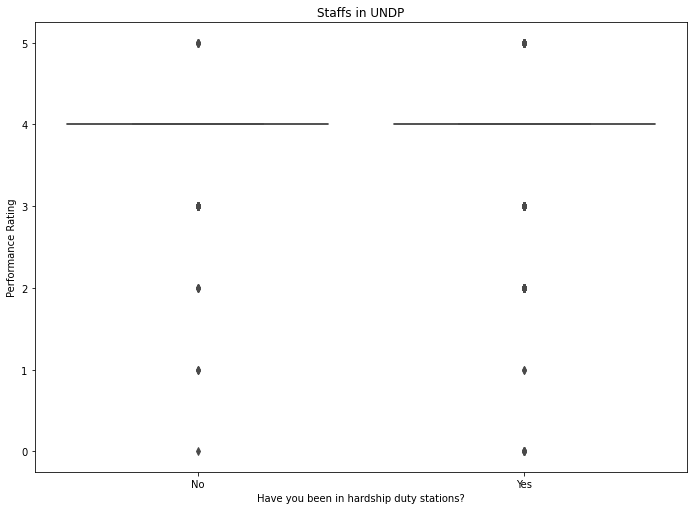

In [416]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=undp,
            x="Hardship_or_not",
            y="Performance_mean", palette="Blues")
plt.title('Staffs in UNDP')
plt.xlabel('Have you been in hardship duty stations?')
plt.ylabel('Performance Rating')
plt.suptitle('')
plt.show();

# We can even see strong negative correlation in Spearman correlation coefficient between Hardship_max and Performance rating in the other Jupyter Notebook.

In [413]:
# make two-way frequency table.
hardship_undp = pd.crosstab(index=undp['Performance_mean'], columns=undp['Hardship_or_not'])

stat, p, dof, ex= chi2_contingency(hardship_undp, correction=True) 
 
significance_level = 0.05
print("p value: " + str(p)) 
if p <= significance_level: 
    print('Reject NULL HYPOTHESIS') 
else: 
    print('Accept NULL HYPOTHESIS') 

p value: 0.001681508085399135
Reject NULL HYPOTHESIS


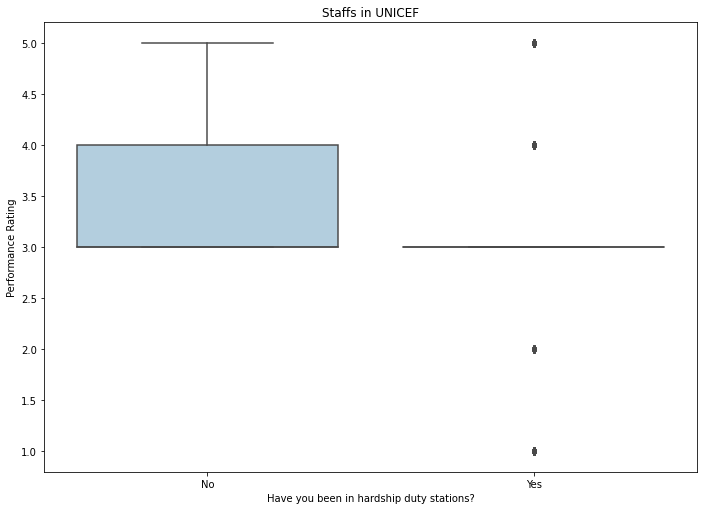

In [402]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=unicef,
            x="Hardship_or_not",
            y="Performance_mean", palette="Blues")
plt.title('Staffs in UNICEF')
plt.xlabel('Have you been in hardship duty stations?')
plt.ylabel('Performance Rating')
plt.suptitle('')
plt.show();

In [411]:
# make two-way frequency table.
hardship_unicef = pd.crosstab(index=unicef['Performance_mean'], columns=unicef['Hardship_or_not'])

stat, p, dof, ex= chi2_contingency(hardship_unicef, correction=True) 
 
significance_level = 0.05
print("p value: " + str(p)) 
if p <= significance_level: 
    print('Reject NULL HYPOTHESIS') 
else: 
    print('Accept NULL HYPOTHESIS') 

p value: 1.30841733432478e-17
Reject NULL HYPOTHESIS


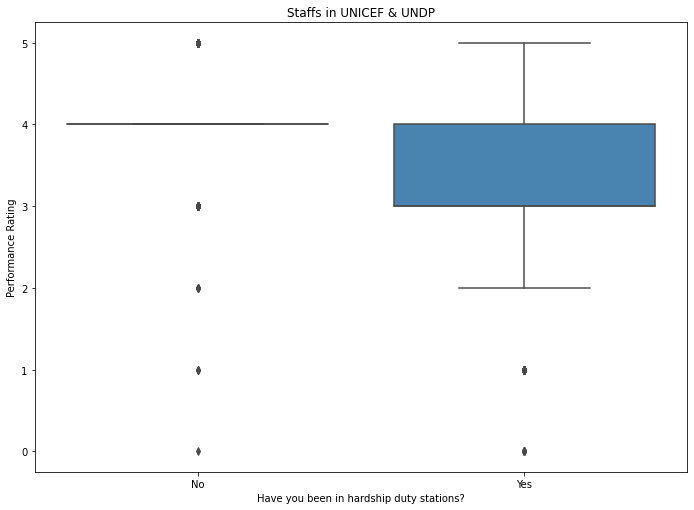

In [404]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=hardship_performance,
            x="Hardship_or_not",
            y="Performance_mean", palette="Blues")
plt.title('Staffs in UNICEF & UNDP')
plt.xlabel('Have you been in hardship duty stations?')
plt.ylabel('Performance Rating')
plt.suptitle('')
plt.show();

In [382]:
# make two-way frequency table.
hardship_freq_ = pd.crosstab(index=hardship_performance['Performance_mean'], columns=hardship_performance['Hardship_or_not'])
hardship_freq_ 

Hardship_or_not,No,Yes
Performance_mean,,
0.0,1,8
1.0,3,61
2.0,5,78
3.0,302,8231
4.0,985,4348
5.0,100,968


In [383]:
from scipy.stats import chi2_contingency 
 
stat, p, dof, ex= chi2_contingency(hardship_freq_, correction=True) 
 
significance_level = 0.05
print("p value: " + str(p)) 
if p <= significance_level: 
    print('Reject NULL HYPOTHESIS') 
else: 
    print('Accept NULL HYPOTHESIS') 

p value: 1.0500978209473745e-186
Reject NULL HYPOTHESIS


# Q) Conclusion???

We can conclude that working at hardship duty and performance score are two dependent variables, so if you have worked in hardship duty location, you are more likely to have better score in performance evaluation???

In [376]:
# # make two-way frequency table.
# hardship_freq = pd.crosstab(index=finaldf['Performance_mean'], columns=finaldf['Hardship_max'])
# hardship_freq 

In [377]:
# from scipy.stats import chi2_contingency 
 
# stat, p, dof, ex= chi2_contingency(hardship_freq, correction=True) 
 
# significance_level = 0.05
# print("p value: " + str(p)) 
# if p <= significance_level: 
#     print('Reject NULL HYPOTHESIS') 
# else: 
#     print('ACCEPT NULL HYPOTHESIS') 

# Hypothesis Testing 2

## Breadth of experience & Promotion
Existing hypothesis: In the current work environment, breadth of experience is as important as depth,
and the more experience you have operating in different environments and
functions makes you more successful in your career

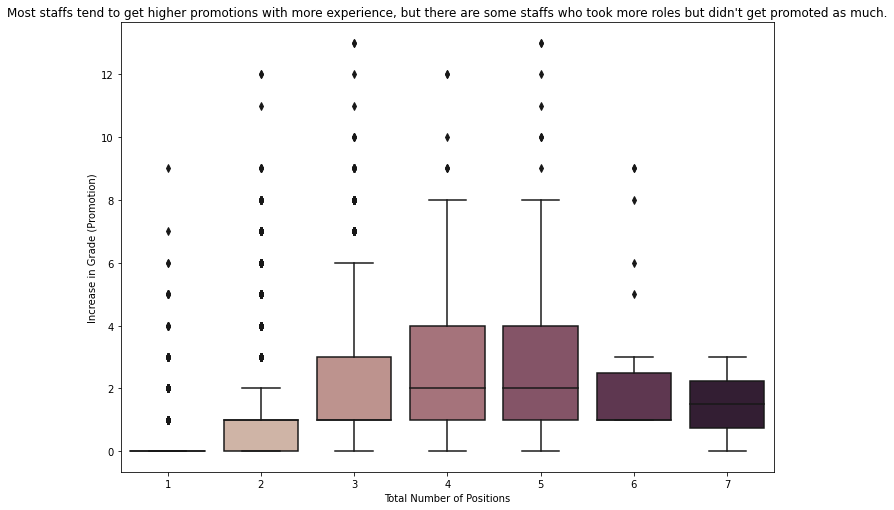

In [315]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=finaldf,
            x="Position_Count",
            y="Difference_incumbent", palette="ch:.25")
plt.title("Most staffs tend to get higher promotions with more experience, but there are some staffs who took more roles but didn't get promoted as much.")
plt.xlabel('Total Number of Positions')
plt.ylabel('Increase in Grade (Promotion)')
plt.show()

In [420]:
multiple_positions = pd.crosstab(index=finaldf['Position_Count'], columns=finaldf['Difference_incumbent'])

multiple_positions

Difference_incumbent,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Position_Count,,,,,,,,,,,,,,
1,7185,501,105,23,6,7,2,1,0,1,0,0,0,0
2,1974,1668,430,171,127,117,51,53,23,5,0,1,2,0
3,436,720,257,103,92,131,72,42,36,11,4,1,1,2
4,62,205,125,30,32,45,26,22,14,3,1,0,2,0
5,17,42,37,5,3,9,7,7,2,1,3,1,1,2
6,0,13,4,1,0,1,1,0,1,2,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [421]:
stat, p, dof, ex= chi2_contingency(multiple_positions, correction=True) 
 
significance_level = 0.05
print("p value: " + str(p)) 
if p <= significance_level: 
    print('Reject NULL HYPOTHESIS') 
else: 
    print('ACCEPT NULL HYPOTHESIS') 

p value: 0.0
Reject NULL HYPOTHESIS


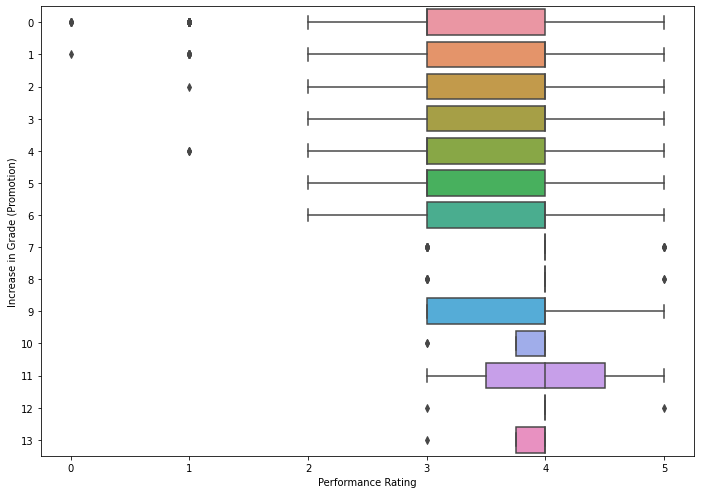

In [387]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.boxplot(data=finaldf,
            x="Performance_mean",
            y="Difference_incumbent", orient='h')
plt.title('')
plt.xlabel('Performance Rating')
plt.ylabel('Increase in Grade (Promotion)')
plt.show()

The performance rating distribution of staffs who have been promoted a lot is located between 3 and 5.

The performance rating distribution of staffs who have been promoted less more spreads out, ranging from 0 to 5.  

# Compare Top 100 & Bottom 100 Performers out of 15090 UN Staffs

In [477]:
top100 = finaldf.sort_values(['Performance_mean'],ascending = False).head(100)
top100['top_bottom'] = 'Top 100'

In [478]:
bottom100 = finaldf.sort_values(['Performance_mean'],ascending = False).tail(100)
bottom100['top_bottom'] = 'Bottom 100'

In [479]:
top_bottom = pd.concat([top100, bottom100])

In [480]:
hard = top_bottom.groupby(['top_bottom','Hardship_max'])['Index No'].count().reset_index()

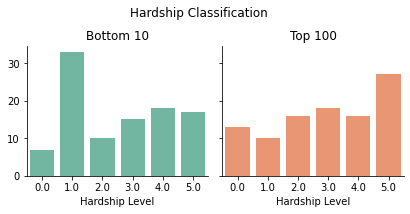

In [493]:
grid = sns.FacetGrid(data=hard, col='top_bottom', hue='top_bottom', palette='Set2')
grid.map(sns.barplot, "Hardship_max", "Index No")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Hardship Classification")

axes = grid.axes.flatten()
axes[0].set_title("Bottom 10")
axes[1].set_title("Top 100")
axes[0].set_ylabel("")
axes[0].set_xlabel("Hardship Level")
axes[1].set_xlabel("Hardship Level")
plt.show();

In [482]:
position = top_bottom.groupby(['top_bottom','Position_Count'])['Index No'].count().reset_index()

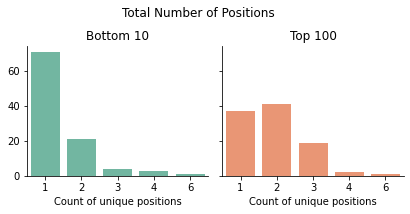

In [494]:
grid = sns.FacetGrid(data=position, col='top_bottom', hue='top_bottom', palette='Set2')
grid.map(sns.barplot, "Position_Count", "Index No")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Total Number of Positions")

axes = grid.axes.flatten()
axes[0].set_title("Bottom 10")
axes[1].set_title("Top 100")
axes[0].set_ylabel("")
axes[0].set_xlabel("Count of unique positions")
axes[1].set_xlabel("Count of unique positions")
plt.show();

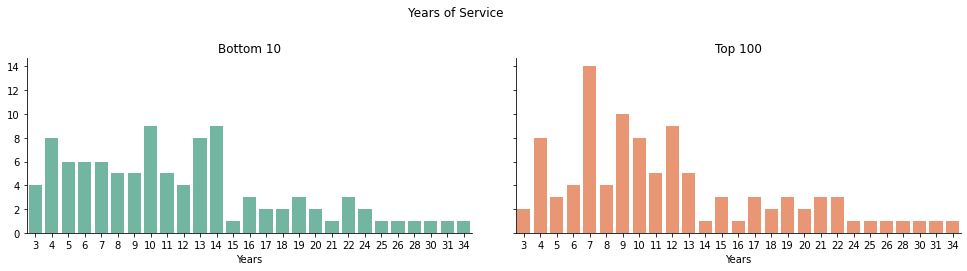

In [492]:
years = top_bottom.groupby(['top_bottom','Years of Service'])['Index No'].count().reset_index()
grid = sns.FacetGrid(data = years, col='top_bottom', hue='top_bottom', palette='Set2')
grid.map(sns.barplot, "Years of Service", "Index No")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Years of Service")

grid.fig.set_size_inches(15,4)
axes = grid.axes.flatten()
axes[0].set_title("Bottom 10")
axes[1].set_title("Top 100")
axes[0].set_ylabel("")
axes[0].set_xlabel("Years")
axes[1].set_xlabel("Years")
plt.show();

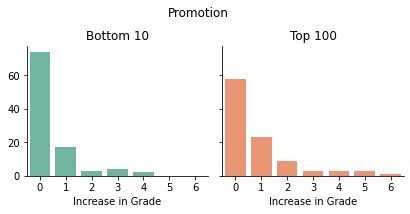

In [491]:
years = top_bottom.groupby(['top_bottom','Difference_incumbent'])['Index No'].count().reset_index()
grid = sns.FacetGrid(data = years, col='top_bottom', hue='top_bottom', palette='Set2')
grid.map(sns.barplot, "Difference_incumbent", "Index No")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle("Promotion")

axes = grid.axes.flatten()
axes[0].set_title("Bottom 10")
axes[1].set_title("Top 100")
axes[0].set_ylabel("")
axes[0].set_xlabel("Increase in Grade")
axes[1].set_xlabel("Increase in Grade")
plt.show();

In [425]:
h = top50.groupby('Hardship_max')['Index No'].count().reset_index()
h.columns = ["Hardship_max","Count"]

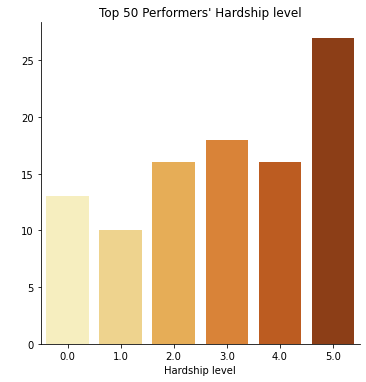

In [426]:
# A is Hard E is the Most hardest and H is for HQ duty station
# hardship_level = {'H': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
fig = sns.catplot(x="Hardship_max", y="Count", kind="bar",palette="YlOrBr", data=h)
plt.xlabel("Hardship level")
plt.ylabel(" ")
plt.title("Top 50 Performers' Hardship level")
#plt.suptitle('Median hardship level of all UN staffs: 3')
plt.show(fig);

In [427]:
p = pd.DataFrame(top50.groupby('Position_Count')['Index No'].count()).reset_index()
p.columns = ["Position_Count","Count"]

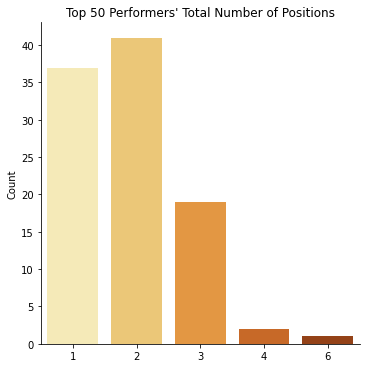

In [428]:
fig = sns.catplot(x="Position_Count", y="Count", kind="bar",palette="YlOrBr", data=p)
plt.xlabel("")
plt.ylabel("Count")
plt.title("Top 50 Performers' Total Number of Positions")
#plt.suptitle('Median total number of positions of all UN staffs: 1')
plt.show(fig);

In [429]:
y = pd.DataFrame(top50.groupby('Years of Service')['Index No'].count()).reset_index()
y.columns = ["Years of Service","Count"]

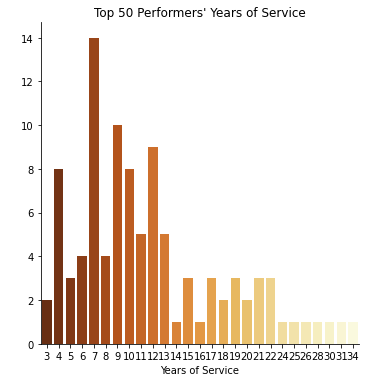

In [430]:
fig = sns.catplot(x="Years of Service", y="Count", kind="bar",palette='YlOrBr_r', data=y)
plt.xlabel("Years of Service")
plt.ylabel(" ")
plt.title("Top 50 Performers' Years of Service") # You can comment this line out if you don't need title
plt.show(fig);

In [ ]:
5-10, 11-20 years - divide the data for grouping. 
most people are in 5-10. shape the data. 

In [431]:
I = pd.DataFrame(top50.groupby('Max_Incumbent')['Index No'].count()).reset_index()
I.columns = ["Max_Incumbent","Count"]

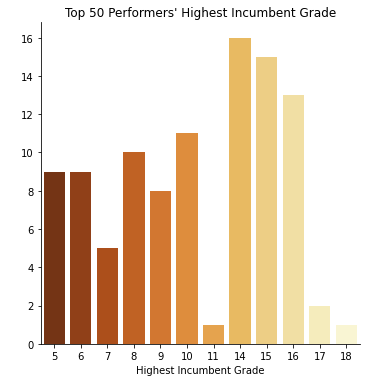

In [432]:
fig = sns.catplot(x="Max_Incumbent", y="Count", kind="bar",palette='YlOrBr_r', data=I)
plt.xlabel("Highest Incumbent Grade")
plt.ylabel(" ")
plt.title("Top 50 Performers' Highest Incumbent Grade") # You can comment this line out if you don't need title
plt.show(fig);

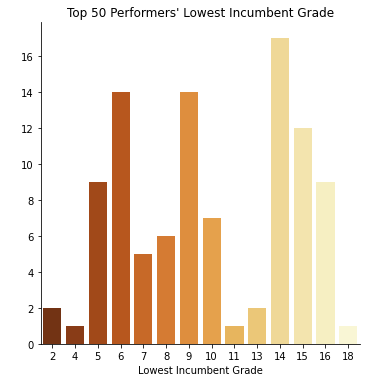

In [433]:
I2 = pd.DataFrame(top50.groupby('Min_Incumbent')['Index No'].count()).reset_index()
I2.columns = ["Min_Incumbent","Count"]
fig = sns.catplot(x="Min_Incumbent", y="Count", kind="bar",palette='YlOrBr_r', data=I2)
plt.xlabel("Lowest Incumbent Grade")
plt.ylabel(" ")
plt.title("Top 50 Performers' Lowest Incumbent Grade") # You can comment this line out if you don't need title
plt.show(fig);

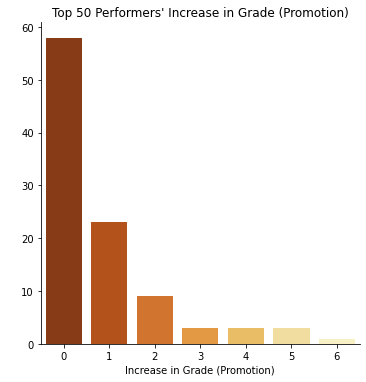

In [434]:
I2 = pd.DataFrame(top50.groupby('Difference_incumbent')['Index No'].count()).reset_index()
I2.columns = ["Difference_incumbent","Count"]
fig = sns.catplot(x="Difference_incumbent", y="Count", kind="bar",palette='YlOrBr_r', data=I2)
plt.xlabel("Increase in Grade (Promotion)")
plt.ylabel(" ")
plt.title("Top 50 Performers' Increase in Grade (Promotion)") # You can comment this line out if you don't need title
plt.show(fig);

In [ ]:
compare with bottom 50.


In [114]:
#finaldf.to_csv('finaldf.csv', index=False)